In [1]:
#Impor Library
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib. pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import LSTM,SimpleRNN,GRU,Dense,Dropout
from sklearn.model_selection import TimeSeriesSplit
import matplotlib. dates as mandates
from sklearn import linear_model
from keras.models import Sequential
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras import optimizers
from tensorflow.keras.optimizers import Adamax, Adam, RMSprop 
from keras.models import load_model
from keras.utils.vis_utils import plot_model
import timeit
from sklearn.metrics import make_scorer, r2_score, confusion_matrix, mean_squared_error
from sklearn import metrics
from math import sqrt

# Tampilan layar
pd.set_option('display.max_rows', 800)
pd.set_option('display.max_columns', 500)

In [2]:
#Ambil Data
df = pd.read_csv("orcl.csv",index_col='Date',parse_dates=True,infer_datetime_format=True)
df.to_pickle('dataset.pkl')   
df = pd.read_pickle('dataset.pkl') 
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5044 entries, 2000-06-30 to 2020-07-20
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5044 non-null   float64
 1   High       5044 non-null   float64
 2   Low        5044 non-null   float64
 3   Close      5044 non-null   float64
 4   Adj Close  5044 non-null   float64
 5   Volume     5044 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 275.8 KB


In [3]:
agg_dict = {'Open': 'first',
          'High': 'max',
          'Low': 'min',
          'Close': 'last',
          'Adj Close': 'last',
          'Volume': 'mean'}

# re-sample dataframe
# 'D' untuk aggreat harian
df = df.resample('5D').agg(agg_dict)

In [4]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-06-30,54.799999,56.430000,54.500000,55.939999,55.704502,1.740720e+07
2020-07-05,56.200001,57.799999,55.990002,57.529999,57.287807,1.420415e+07
2020-07-10,57.470001,57.840000,56.480000,57.200001,57.200001,1.469723e+07
2020-07-15,57.419998,57.840000,54.759998,54.900002,54.900002,1.123163e+07
2020-07-20,54.880001,55.514999,54.695000,55.450001,55.450001,9.410108e+06


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1466 entries, 2000-06-30 to 2020-07-20
Freq: 5D
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1466 non-null   float64
 1   High       1466 non-null   float64
 2   Low        1466 non-null   float64
 3   Close      1466 non-null   float64
 4   Adj Close  1466 non-null   float64
 5   Volume     1466 non-null   float64
dtypes: float64(6)
memory usage: 120.2 KB


In [6]:
#Print cek data kosong
print("Dataframe Shape: ", df. shape)
print("Null Value Present: ", df.isnull().values.any())

Dataframe Shape:  (1466, 6)
Null Value Present:  False


In [7]:
#pengisian data kosong
df = df.fillna(method = "ffill")

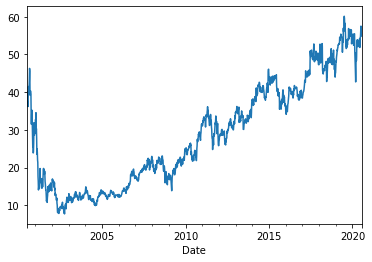

In [8]:
#Plot Nilai Close
df["Close"].plot()

In [9]:
#Tentukan Target
output_var = pd.DataFrame(df['Close'])
#Pilih Features
features = ['Open', 'High', 'Low', 'Volume']

In [10]:
#Skala Data
scaler = StandardScaler()# standar scaler lebih baik
#scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df[features])
feature_transform= pd.DataFrame(columns=features, data=feature_transform, index=df.index)
feature_transform.head()

,Open,High,Low,Volume
Date,,,,
2000-06-30,0.824371,0.914391,0.824959,0.569240
2000-07-05,0.696241,0.669944,0.565994,1.664611
2000-07-10,0.617564,0.634388,0.543277,0.490002
2000-07-15,0.642291,0.683278,0.611426,0.055063
2000-07-20,0.624308,0.718833,0.675032,0.258420


In [11]:
#Split Data Train set and Test set
timesplit= TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(feature_transform):
        X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [12]:
#Reshape Data
trainX =np.array(X_train)
testX =np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

In [13]:
#Rencana Model

jml_epochs= 100
input_optimasi = 'Adam'
input_lr = '01'

#Set optimizer
if input_lr == '01':
  lr=0.1
elif input_lr == '001':
  lr=0.01
elif input_lr == '0001':
  lr=0.001

if input_optimasi == 'Adamax':
  opt = Adamax(learning_rate=lr)
elif input_optimasi == 'Adam':
  opt = Adam(learning_rate=lr)
elif input_optimasi == 'RMSprop':
  opt = RMSprop(learning_rate=lr)


model = Sequential()
model.add(SimpleRNN(32, input_dim=len(features), activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae','mse'])




model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1184      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1,217
Trainable params: 1,217
Non-trainable params: 0
_________________________________________________________________


In [14]:
#Model Training

start = timeit.default_timer()
history=model.fit(X_train, y_train, epochs=jml_epochs, batch_size=16, verbose=1, shuffle=False)
stop = timeit.default_timer()

Epoch 1/100
84/84 [==============================] - 3s 5ms/step - loss: 79.3972 - mae: 6.3631 - mse: 79.3972
Epoch 2/100
84/84 [==============================] - 0s 5ms/step - loss: 33.5746 - mae: 4.8767 - mse: 33.5746
Epoch 3/100
84/84 [==============================] - 0s 5ms/step - loss: 25.7312 - mae: 4.1837 - mse: 25.7312
Epoch 4/100
84/84 [==============================] - 0s 5ms/step - loss: 31.9360 - mae: 4.4038 - mse: 31.9360
Epoch 5/100
84/84 [==============================] - 0s 5ms/step - loss: 51.8899 - mae: 6.0006 - mse: 51.8899
Epoch 6/100
84/84 [==============================] - 0s 5ms/step - loss: 26.0145 - mae: 4.1215 - mse: 26.0145
Epoch 7/100
84/84 [==============================] - 0s 5ms/step - loss: 17.6484 - mae: 3.2795 - mse: 17.6484
Epoch 8/100
84/84 [==============================] - 0s 5ms/step - loss: 9.5445 - mae: 2.2276 - mse: 9.5445
Epoch 9/100
84/84 [==============================] - 0s 5ms/step - loss: 10.2060 - mae: 2.4466 - mse: 10.2060
Epoch 10/100

In [15]:
#Model Prediksi
y_pred= model.predict(X_test)

In [16]:
print ('R Squared =',r2_score(y_test, y_pred))
ORCL_R2_MODEL = r2_score(y_test, y_pred)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
ORCL_MAE_MODEL = metrics.mean_absolute_error(y_test, y_pred)

print('Mean Absolute Percentage Error:', metrics.mean_absolute_percentage_error(y_test, y_pred))
ORCL_MAPE_MODEL = metrics.mean_absolute_percentage_error(y_test, y_pred)

print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
ORCL_RMSE_MODEL = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

R Squared = 0.9508065427993293
Mean Absolute Error: 0.5838588101210054
Mean Absolute Percentage Error: 0.011276717876064334
Root Mean Squared Error: 0.7537734287156531


In [17]:
#Kompilasi Performa Eror
from prettytable import PrettyTable
waktu = stop - start
nmtabel = PrettyTable(["Model","Epoch","LR","OPT","R2","MAE","MAPE","RMSE","Waktu"])
nmtabel.add_row(["RNN",jml_epochs,input_lr,input_optimasi,'{:.2f}'.format(ORCL_R2_MODEL), '{:.2f}'.format(ORCL_MAE_MODEL), '{:.2f}'.format(ORCL_MAPE_MODEL), '{:.2f}'.format(ORCL_RMSE_MODEL),'{:.0f}'.format(waktu)])
#nmtabel.add_row(["5","Paper Acuan","ORCL","LSTM","100","01","Adam","0.90153", "0.98621","1.97875","1.39695","-"])
print(nmtabel)

+-------+-------+----+------+------+------+------+------+-------+
| Model | Epoch | LR | OPT  |  R2  | MAE  | MAPE | RMSE | Waktu |
+-------+-------+----+------+------+------+------+------+-------+
|  RNN  |  100  | 01 | Adam | 0.95 | 0.58 | 0.01 | 0.75 |   83  |
+-------+-------+----+------+------+------+------+------+-------+


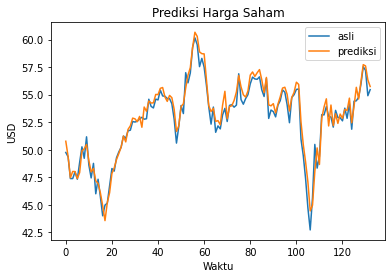

In [18]:
#Grafik Asli dan Prediksi 
plt.plot(y_test, label='asli')
plt.plot(y_pred, label='prediksi')
plt.title("Prediksi Harga Saham")
plt.xlabel('Waktu')
plt.ylabel('USD')
plt.legend()
plt.show()

In [19]:
#Hapus Sesi
K.clear_session()